<a href="https://colab.research.google.com/github/23435339/Weather-Wise-Srijana/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyinputplus matplotlib requests

## 📦 Setup and Configuration
Import required packages and setup environment.

In [2]:
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import pyinputplus as pyip
import ipywidgets as widgets
from IPython.display import display, clear_output
import random



## 🌤️ Weather Data Functions

In [3]:
# Define get_weather_data() function here
def get_weather_data(location, forecast_days=3):
    """
    Obtain forecast details for a selected city and duration via wttr.in, limiting the days as recommended.
    """
    endpoint = f"https://wttr.in/{location}?format=j1"
    data = None

    try:
        response = requests.get(endpoint, timeout=10)
        if response.status_code == 200:
            info = response.json()
            if 'weather' in info:
                limited_data = info.copy()
                limited_data['weather'] = info['weather'][:forecast_days]
                data = limited_data
        else:
            print(f"Request failed with status: {response.status_code}")
    except requests.exceptions.RequestException as error:
        print(f"Unable to retrieve forecast: {error}")

    return data


## 📊 Visualisation Functions

In [4]:
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Display daily max & min temperatures using weather-themed vertical bars.
    """
    dates = [day['date'] for day in weather_data.get('weather', [])]
    max_temps = [float(day.get('maxtempC', 0)) for day in weather_data.get('weather', [])]
    min_temps = [float(day.get('mintempC', 0)) for day in weather_data.get('weather', [])]

    x = np.arange(len(dates))
    width = 0.35

    plt.figure(figsize=(8, 5))

    # Bar chart with weather-color theme
    bars_min = plt.bar(x - width/2, min_temps, width, color='#4FC3F7', edgecolor='#0288D1', label='Min Temp (°C)', alpha=0.9)
    bars_max = plt.bar(x + width/2, max_temps, width, color='#FFB74D', edgecolor='#E65100', label='Max Temp (°C)', alpha=0.9)

    # Add value labels above bars
    for bar in bars_max:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{height:.1f}', ha='center', va='bottom', fontsize=9, color='#E65100')
    for bar in bars_min:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{height:.1f}', ha='center', va='bottom', fontsize=9, color='#01579B')

    plt.xticks(x, dates, rotation=25)
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.title("Daily Temperature Overview")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [5]:

def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Display total daily rainfall as vertical bars with color intensity based on amount.
    """
    dates = [day['date'] for day in weather_data.get('weather', [])]
    totals = []

    # Calculate total daily precipitation
    for day in weather_data.get('weather', []):
        hourly_rain = [float(hour.get('precipMM', 0)) for hour in day.get('hourly', [])]
        total_rain = sum(hourly_rain)
        totals.append(total_rain)

    x = np.arange(len(dates))

    colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(totals)))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(x, totals, color=colors, edgecolor='black', alpha=0.85)

    plt.xticks(x, dates, rotation=25)
    plt.xlabel("Date")
    plt.ylabel("Total Rainfall (mm)")
    plt.title("Daily Total Precipitation Overview")
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    for bar, total in zip(bars, totals):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1,
                 f'{height:.1f}', ha='center', va='bottom', fontsize=9, color='black')

    plt.tight_layout()
    plt.show()



In [6]:
def create_wind_visualisation(weather_data, output_type='display'):
    """
    Average wind speed per day shown as a smooth gradient filled area chart.
    """
    dates = []
    avg_wind_speed = []  # renamed variable to reflect actual data

    for day in weather_data.get('weather', []):
        dates.append(day['date'])
        wind_speeds = [float(hour.get('windspeedKmph', 0)) for hour in day.get('hourly', [])]
        avg = sum(wind_speeds) / len(wind_speeds) if wind_speeds else 0
        avg_wind_speed.append(avg)

    plt.figure(figsize=(8, 5))
    plt.plot(dates, avg_wind_speed, color='#1565C0', lw=2)

    # Gradient fill effect with dynamic opacity
    for i in range(len(dates) - 1):
        plt.fill_between(dates[i:i + 2], avg_wind_speed[i:i + 2], color='#90CAF9', alpha=0.4 * (i + 1) / len(dates))

    plt.title("Average Daily Wind Speed")
    plt.xlabel("Date")
    plt.ylabel("Wind Speed (km/h)")
    plt.grid(alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()

## 🤖 Natural Language Processing

In [7]:
def parse_weather_question(question):

    question = question.lower().strip()
    features = ['temperature', 'precipitation', 'rain', 'rainfall', 'wind']
    time_markers = ['today', 'tomorrow', 'day after tomorrow']
    city = None
    focus = None
    day_ref = 'today'  # default

    # --- Identify weather feature ---
    for word in question.split():
        for f in features:
            if f in word or word.startswith(f[:4]):
                focus = f
                break
        if focus:
            break

    if focus in ['rain', 'rainfall']:
        focus = 'precipitation'


    for marker in time_markers:
        if marker in question:
            day_ref = marker
            break


    for vague in ['next', 'later', 'upcoming']:
        if vague in question and day_ref == 'today':
            day_ref = 'tomorrow'

    tokens = question.split()
    for prep in ['in', 'at']:
        if prep in tokens:
            idx = tokens.index(prep)
            if idx + 1 < len(tokens):
                city = tokens[idx + 1].capitalize()
                break
    if not city:
        city = 'Perth'

    return {'city': city, 'element': focus, 'period': day_ref}


## 🧩 Main Application Logic

In [8]:
# Tie everything together here
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a text response for temperature, precipitation or wind forecast.
    """
    city = parsed_question.get('city', 'Unknown').title()
    element = parsed_question.get('element')
    period = parsed_question.get('period', 'today').lower()

    # Reworked logic for day indexing
    day_map = {'today': 0, 'tomorrow': 1, 'day after tomorrow': 2}
    day_index = day_map.get(period, 0)

    try:
        selected_day = weather_data.get('weather', [])[day_index]
        hourly_data = selected_day.get('hourly', [])

        if not element or element == 'temperature':
            avg_temp = sum((float(h.get('tempC', 0)) for h in hourly_data)) / len(hourly_data) if hourly_data else 0
            return f"In {city} on {selected_day['date']}, the average temperature will be around {avg_temp:.1f}°C."

        elif element in ['precipitation', 'rain']:
            precip_values = [float(h.get('precipMM', 0)) for h in hourly_data]
            max_rain = max(precip_values) if precip_values else 0
            return f"In {city} on {selected_day['date']}, the heaviest rainfall is expected to reach {max_rain:.1f} mm in an hour."

        elif element == 'wind':
            wind_values = [float(h.get('windspeedKmph', 0)) for h in hourly_data]
            avg_wind = sum(wind_values) / len(wind_values) if wind_values else 0
            return f"In {city} on {selected_day['date']}, the average wind speed will be {avg_wind:.1f} km/h."

        else:
            return "Sorry, only temperature, precipitation and wind data are supported."

    except (IndexError, KeyError, TypeError):
        return "Sorry, weather data is not available for the requested time."


## 🧭 User Interface

In [11]:

def weather_menu():
    title = widgets.HTML(value="<h2>🌤️ Weather Wise</h2><p>Select an option below:</p>")

    # Create main menu buttons
    btn_question = widgets.Button(description="Ask Weather Question", button_style='info')
    btn_temp = widgets.Button(description="Temperature Chart", button_style='warning')
    btn_rain = widgets.Button(description="Precipitation Chart", button_style='primary')
    btn_wind = widgets.Button(description="Wind Chart", button_style='success')
    btn_exit = widgets.Button(description="Exit", button_style='danger')

    menu_box = widgets.VBox([title, btn_question, btn_temp, btn_rain, btn_wind, btn_exit])
    display(menu_box)

    # --- handlers for each option ---
    def ask_question(b):
        clear_output()
        city_box = widgets.Text(description="City:", placeholder="Enter city name")

        # 🔹 Updated question list (3 days only, no humidity)
        question_dropdown = widgets.Dropdown(
            options=[
                "What is the temperature today?",
                "How hot will it be tomorrow?",
                "What’s the temperature day after tomorrow?",
                "Will it rain today?",
                "How much rainfall is expected tomorrow?",
                "Will it rain day after tomorrow?",
                "What is the wind speed today?",
                "How windy will it be tomorrow?",
                "What will the wind be like day after tomorrow?",
                "Is there a strong wind expected tomorrow?",
                "Will there be any rain in Perth today?",
                "What is the temperature range tomorrow?"
            ],
            description="Question:"
        )

        run_btn = widgets.Button(description="Get Answer", button_style='success')
        back_btn = widgets.Button(description="Back", button_style='info')
        display(city_box, question_dropdown, widgets.HBox([run_btn, back_btn]))

        def run_action(r):
            clear_output()
            city = city_box.value or "Perth"
            data = get_weather_data(city, forecast_days=3)
            question = question_dropdown.value
            parsed = parse_weather_question(question)
            parsed['city'] = city
            print(f" {question}\n")
            print(f" {generate_weather_response(parsed, data)}")
            display(back_btn)

        run_btn.on_click(run_action)
        back_btn.on_click(lambda _: (clear_output(), weather_menu()))

    def show_temp(b):
        clear_output()
        city_box = widgets.Text(description="City:", placeholder="Enter city name")
        run_btn = widgets.Button(description="Show Chart", button_style='success')
        back_btn = widgets.Button(description="Back", button_style='info')
        display(city_box, run_btn, back_btn)

        def run_action(r):
            clear_output()
            city = city_box.value or "Perth"
            data = get_weather_data(city, forecast_days=3)
            create_temperature_visualisation(data)
            display(back_btn)
        run_btn.on_click(run_action)
        back_btn.on_click(lambda _: (clear_output(), weather_menu()))

    def show_rain(b):
        clear_output()
        city_box = widgets.Text(description="City:", placeholder="Enter city name")
        run_btn = widgets.Button(description="Show Chart", button_style='success')
        back_btn = widgets.Button(description="Back", button_style='info')
        display(city_box, run_btn, back_btn)

        def run_action(r):
            clear_output()
            city = city_box.value or "Perth"
            data = get_weather_data(city, forecast_days=3)
            create_precipitation_visualisation(data)
            display(back_btn)
        run_btn.on_click(run_action)
        back_btn.on_click(lambda _: (clear_output(), weather_menu()))

    def show_wind(b):
        clear_output()
        city_box = widgets.Text(description="City:", placeholder="Enter city name")
        run_btn = widgets.Button(description="Show Chart", button_style='success')
        back_btn = widgets.Button(description="Back", button_style='info')
        display(city_box, run_btn, back_btn)

        def run_action(r):
            clear_output()
            city = city_box.value or "Perth"
            data = get_weather_data(city, forecast_days=3)
            create_wind_visualisation(data)
            display(back_btn)
        run_btn.on_click(run_action)
        back_btn.on_click(lambda _: (clear_output(), weather_menu()))

    def exit_menu(b):
        clear_output()
        display(widgets.HTML(value="<h3>✅ Exiting Weather Wise... Stay weather-smart!</h3>"))

    # --- Connect main menu buttons ---
    btn_question.on_click(ask_question)
    btn_temp.on_click(show_temp)
    btn_rain.on_click(show_rain)
    btn_wind.on_click(show_wind)
    btn_exit.on_click(exit_menu)


In [12]:
weather_menu()

## 🧪 Testing and Examples

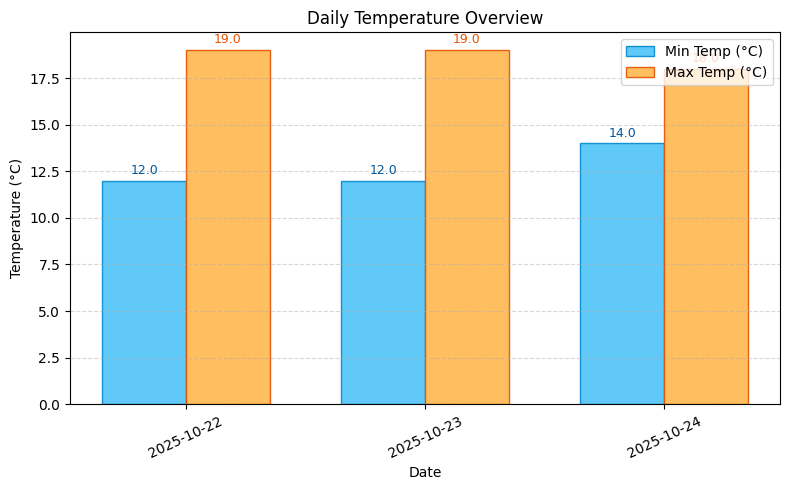

In [13]:
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Display daily max & min temperatures using weather-themed vertical bars.
    """
    dates = [day['date'] for day in weather_data.get('weather', [])]
    max_temps = [float(day.get('maxtempC', 0)) for day in weather_data.get('weather', [])]
    min_temps = [float(day.get('mintempC', 0)) for day in weather_data.get('weather', [])]

    x = np.arange(len(dates))
    width = 0.35

    plt.figure(figsize=(8, 5))

    # Bar chart with weather-color theme
    bars_min = plt.bar(x - width/2, min_temps, width, color='#4FC3F7', edgecolor='#0288D1', label='Min Temp (°C)', alpha=0.9)
    bars_max = plt.bar(x + width/2, max_temps, width, color='#FFB74D', edgecolor='#E65100', label='Max Temp (°C)', alpha=0.9)

    # Add value labels above bars
    for bar in bars_max:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{height:.1f}', ha='center', va='bottom', fontsize=9, color='#E65100')
    for bar in bars_min:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{height:.1f}', ha='center', va='bottom', fontsize=9, color='#01579B')

    plt.xticks(x, dates, rotation=25)
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.title("Daily Temperature Overview")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
# --- Testing the Temperature Visualisation ---
city = "Perth"
sample_data = get_weather_data(city, forecast_days=3)
create_temperature_visualisation(sample_data)


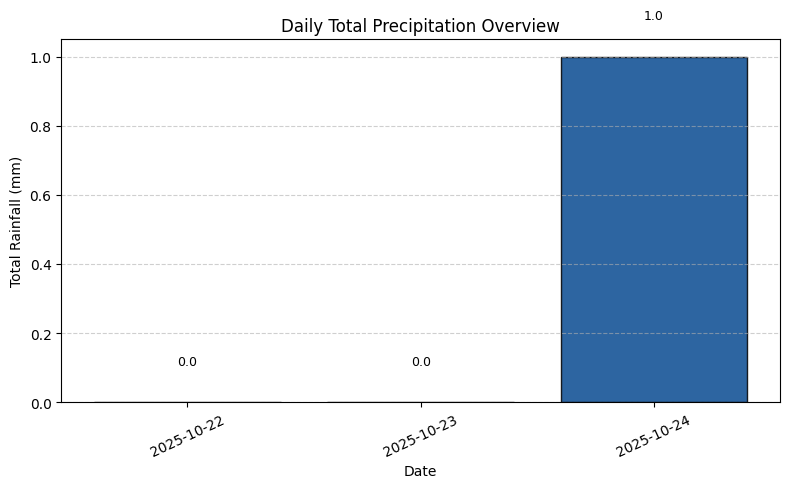

In [14]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Display total daily rainfall as vertical bars with color intensity based on amount.
    """
    dates = [day['date'] for day in weather_data.get('weather', [])]
    totals = []

    # Calculate total daily precipitation
    for day in weather_data.get('weather', []):
        hourly_rain = [float(hour.get('precipMM', 0)) for hour in day.get('hourly', [])]
        total_rain = sum(hourly_rain)
        totals.append(total_rain)

    x = np.arange(len(dates))

    colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(totals)))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(x, totals, color=colors, edgecolor='black', alpha=0.85)

    plt.xticks(x, dates, rotation=25)
    plt.xlabel("Date")
    plt.ylabel("Total Rainfall (mm)")
    plt.title("Daily Total Precipitation Overview")
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    for bar, total in zip(bars, totals):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1,
                 f'{height:.1f}', ha='center', va='bottom', fontsize=9, color='black')

    plt.tight_layout()
    plt.show()
    # --- Testing the Precipitation Visualisation ---
city = "Perth"
sample_data = get_weather_data(city, forecast_days=3)
create_precipitation_visualisation(sample_data)


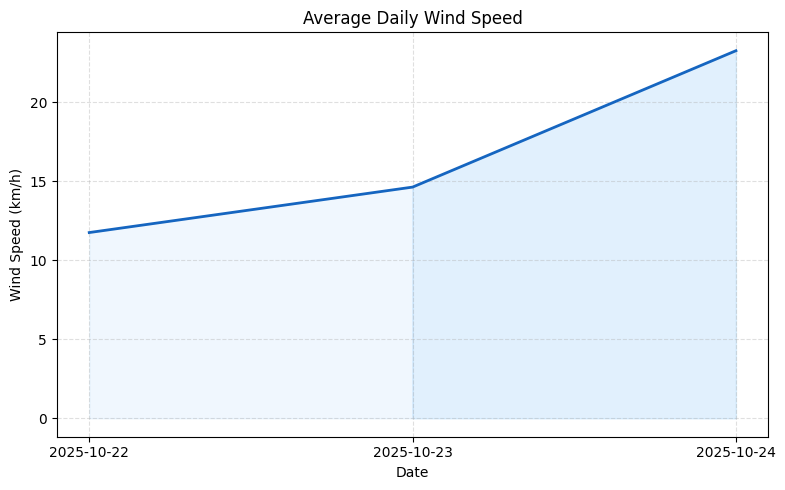

In [15]:
def create_wind_visualisation(weather_data, output_type='display'):
    """
    Average wind speed per day shown as a smooth gradient filled area chart.
    """
    dates = []
    avg_wind_speed = []  # renamed variable to reflect actual data

    for day in weather_data.get('weather', []):
        dates.append(day['date'])
        wind_speeds = [float(hour.get('windspeedKmph', 0)) for hour in day.get('hourly', [])]
        avg = sum(wind_speeds) / len(wind_speeds) if wind_speeds else 0
        avg_wind_speed.append(avg)

    plt.figure(figsize=(8, 5))
    plt.plot(dates, avg_wind_speed, color='#1565C0', lw=2)

    # Gradient fill effect with dynamic opacity
    for i in range(len(dates) - 1):
        plt.fill_between(dates[i:i + 2], avg_wind_speed[i:i + 2], color='#90CAF9', alpha=0.4 * (i + 1) / len(dates))

    plt.title("Average Daily Wind Speed")
    plt.xlabel("Date")
    plt.ylabel("Wind Speed (km/h)")
    plt.grid(alpha=0.4, linestyle='--')
    plt.tight_layout()
    plt.show()

    # --- Testing the Wind Speed Visualisation ---
city = "Perth"
sample_data = get_weather_data(city, forecast_days=3)
create_wind_visualisation(sample_data)


## 🗂️ AI Prompting Log (Optional)
Here is the link for AI-conversation https://github.com/23435339/Weather-Wise-Srijana/tree/main/ai-conversations